In [44]:
import os
import datetime
import random
import statistics as stat
from pathlib import Path
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [45]:
import cv2 
from imutils import paths

In [46]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [47]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [48]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [49]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [50]:
def load_image_folder(df_metadata, col_img_name, input_dataset_path,
                      output_dataset_path):
    img_number = 0
    # loop over the rows of the COVID-19 data frame
    for (i, row) in df_metadata.iterrows():

        # build the path to the input image file
        imagePath = os.path.sep.join([input_dataset_path, row[col_img_name]])

        # if the input image file does not exist (there are some errors in
        # the metadeta file), ignore the row
        if not os.path.exists(imagePath):
            print('image not found')
            continue

        # extract the filename from the image path and then construct the
        # path to the copied image file
        filename = row[col_img_name].split(os.path.sep)[-1]
        outputPath = os.path.sep.join([f"{output_dataset_path}", filename])

        # copy the image
        shutil.copy2(imagePath, outputPath)
        img_number += 1
    print('{} selected Images on folder {}:'.format(img_number,
                                                    output_dataset_path))

In [51]:
def load_image_folder_direct(input_dataset_path, output_dataset_path,
                             img_num_select):
    img_number = 0
    pathlist = Path(input_dataset_path).glob('**/*.*')
    nof_samples = img_num_select
    rc = []
    for k, path in enumerate(pathlist):
        if k < nof_samples:
            rc.append(str(path))  # because path is object not string
            shutil.copy2(path, output_dataset_path)
            img_number += 1
        else:
            i = random.randint(0, k)
            if i < nof_samples:
                rc[i] = str(path)

    print('{} selected Images on folder {}:'.format(img_number,
                                                    output_dataset_path))

In [52]:
def ceildiv(a, b):
    return -(-a // b)

In [53]:
def plots_from_files(imspaths,
                     figsize=(10, 5),
                     rows=1,
                     titles=None,
                     maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None:
        plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [54]:
def test_rx_image_for_Covid19(imagePath):
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)

    img = np.array(img) / 255.0

    pred = new_model.predict(img)
    pred_neg = round(pred[0][1] * 100)
    pred_pos = round(pred[0][0] * 100)

    # for each image in the testing set we need to find the index of the
    # label with corresponding largest predicted probability
    # print(np.argmax(pred, axis=1))

    print('\n X-Ray Covid-19 Detection using AI - MJRovai')
    print('    [WARNING] - Only for didactic purposes')
    if np.argmax(pred, axis=1)[0] == 1:
        plt.title(
            '\nPrediction: [NEGATIVE] with prob: {}% \nNo Covid-19\n'.format(
                pred_neg),
            fontsize=12)
    else:
        plt.title(
            '\nPrediction: [POSITIVE] with prob: {}% \nPneumonia by Covid-19 Detected\n'
            .format(pred_pos),
            fontsize=12)

    img_out = plt.imread(imagePath)
    plt.imshow(img_out)
    plt.savefig('../Image_Prediction/Image_Prediction.png')
    return pred_pos

In [55]:
def test_rx_image_for_Covid19_2(imagePath, neg_cnt, pos_cnt):
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis = 0)

    img = np.array(img) / 255.0

    pred = new_model.predict(img)

    # for each image in the testing set we need to find the index of the
    # label with corresponding largest predicted probability
    # print(np.argmax(pred, axis=1))
    
    if np.argmax(pred, axis=1)[0] == 1:
        neg_cnt +=1
    else:
        pos_cnt +=1
        
    return pred[0][0], neg_cnt, pos_cnt

In [56]:
def test_rx_image_for_Covid19_batch(img_lst):
    neg_cnt = 0
    pos_cnt = 0
    predictions_score = []
    for img in img_lst:
        pred, neg_cnt, pos_cnt = test_rx_image_for_Covid19_2(img, neg_cnt, pos_cnt)
        predictions_score.append(pred)
    print ('{} positive detected in a total of {} images'.format(pos_cnt, (pos_cnt+neg_cnt)))
    return  predictions_score, neg_cnt, pos_cnt

In [57]:
def plot_prediction_distribution(dist, name='Dataset Prediction Score Distribution'):
    f, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
    sns.despine(left=True)
    sns.distplot(dist, hist=True, color = 'royalblue', ax=axes[0])
    sns.boxplot(dist, color = 'firebrick', ax=axes[1])
    plt.suptitle(name, size = 20)
    plt.setp(axes, yticks=[]);



In [58]:
def plot_accuraccy(history):
    plt.style.use('seaborn-paper')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [61]:
ls input

 Volume in drive C is OS
 Volume Serial Number is 004D-2377

 Directory of C:\Users\USER\X-Ray_Covide_development\input

05/17/2022  02:53 PM    <DIR>          .
05/17/2022  02:56 PM    <DIR>          ..
05/17/2022  02:53 PM    <DIR>          10_Covid_Images
05/17/2022  02:53 PM    <DIR>          20_Chest_Xray
               0 File(s)              0 bytes
               4 Dir(s)  55,271,264,256 bytes free


In [87]:
input_dataset_path = r"C:\Users\USER\X-Ray_Covide_development\input\10_Covid_Images"

In [88]:
csvPath = os.path.sep.join([input_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)
df.shape

(950, 30)

In [89]:
df.head(2)

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   patientid               950 non-null    object 
 1   offset                  697 non-null    float64
 2   sex                     870 non-null    object 
 3   age                     713 non-null    float64
 4   finding                 950 non-null    object 
 5   RT_PCR_positive         593 non-null    object 
 6   survival                361 non-null    object 
 7   intubated               248 non-null    object 
 8   intubation_present      250 non-null    object 
 9   went_icu                397 non-null    object 
 10  in_icu                  335 non-null    object 
 11  needed_supplemental_O2  90 non-null     object 
 12  extubated               37 non-null     object 
 13  temperature             78 non-null     float64
 14  pO2_saturation          119 non-null    fl

In [92]:
df.groupby('view').count()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
view,,,,,,,,,,,,,,,,,,,,,
AP,203,136,179,180,203,145,50,71,72,69,...,127,189,203,203,76,203,136,195,103,2
AP Erect,1,0,1,1,1,0,0,0,0,0,...,0,1,1,1,0,1,1,1,1,0
AP Supine,234,206,224,114,234,138,138,48,48,172,...,211,228,234,234,167,234,177,113,74,1
Axial,68,36,59,64,68,68,14,17,17,9,...,41,68,68,68,10,68,58,68,31,0
Coronal,16,1,8,13,16,16,6,6,6,0,...,3,16,16,16,3,16,16,16,0,0
L,84,53,84,81,84,25,28,18,19,16,...,44,80,84,84,3,84,72,84,61,0
PA,344,265,315,260,344,201,125,88,88,131,...,235,312,344,344,123,344,245,291,166,2


In [93]:
df.modality.value_counts()

X-ray    866
CT        84
Name: modality, dtype: int64

In [94]:
xray = df[df.modality == 'X-ray'].copy()
xray.shape

(866, 30)

In [95]:
xray.view.value_counts()

PA           344
AP Supine    234
AP           203
L             84
AP Erect       1
Name: view, dtype: int64

In [96]:
xray.finding.value_counts()

Pneumonia/Viral/COVID-19                   504
todo                                        83
Pneumonia                                   81
Pneumonia/Fungal/Pneumocystis               30
Pneumonia/Bacterial/Streptococcus           22
No Finding                                  18
Tuberculosis                                18
Pneumonia/Viral/SARS                        16
Pneumonia/Lipoid                            13
Pneumonia/Bacterial/Mycoplasma              11
Pneumonia/Viral/MERS-CoV                    10
Pneumonia/Bacterial/Klebsiella              10
Pneumonia/Bacterial/Legionella              10
Pneumonia/Bacterial/Nocardia                 8
Pneumonia/Viral/Varicella                    6
Pneumonia/Viral/Influenza                    5
Pneumonia/Bacterial                          4
Pneumonia/Bacterial/E.Coli                   4
Pneumonia/Viral/Herpes                       3
Pneumonia/Bacterial/Chlamydophila            3
Pneumonia/Viral/Influenza/H1N1               2
Pneumonia/Fun

In [104]:
xray[xray.finding == 'Pneumonia/Viral/COVID-19'].view.value_counts()

PA           196
AP           146
AP Supine    136
L             26
Name: view, dtype: int64

In [105]:
xray_cv = xray[(xray.finding == 'Pneumonia/Viral/COVID-19') & (xray.view == 'PA')].copy()
xray_cv.reset_index(drop=True, inplace=True)
xray_cv.shape

(196, 30)

In [107]:
# Total of Xrays 
len(xray_cv.patientid)

196

In [108]:
# Total of unique pacients 
len(set(xray_cv.patientid))

139

In [109]:
xray_cv.date.value_counts()

2020                 122
January 22, 2020       3
January 25, 2020       2
Feb 21, 2020           2
03/16/20               2
January 1, 2020        2
January 27, 2020       2
01/13/20               1
December 29, 2019      1
Feb 18, 2020           1
December 30, 2019      1
2/29/2020              1
Jan 28, 2020           1
Jan 24, 2020           1
Feb 17, 2020           1
February 18, 2020      1
Feb 16, 2020           1
January 12, 2020       1
Feb 5, 2020            1
March 10, 2020         1
March 4, 2020          1
Mar 3, 2020            1
January 26, 2020       1
January 24, 2020       1
January 19, 2020       1
January 10, 2020       1
January 6, 2020        1
January 30, 2020       1
January 28, 2020       1
February 25, 2020      1
Name: date, dtype: int64

In [110]:
xray_cv[xray_cv.date == '03/16/20'].filename

58    2966893D-5DDF-4B68-9E2B-4979D5956C8E.jpeg
59    6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg
Name: filename, dtype: object

In [114]:
xray_cv[xray_cv.date == 'March 10, 2020'].filename

36    E63574A7-4188-4C8D-8D17-9D67A18A1AFA.jpeg
Name: filename, dtype: object

In [115]:
xray_cv[xray_cv.date == 'March 4, 2020'].filename

35    F4341CE7-73C9-45C6-99C8-8567A5484B63.jpeg
Name: filename, dtype: object

In [116]:
xray_cv[xray_cv.date == 'Mar 3, 2020'].filename

23    7C69C012-7479-493F-8722-ABC29C60A2DD.jpeg
Name: filename, dtype: object

In [121]:
imgs_march = [
    '2966893D-5DDF-4B68-9E2B-4979D5956C8E.jpeg',
    '6C94A287-C059-46A0-8600-AFB95F4727B7.jpeg',
    'E63574A7-4188-4C8D-8D17-9D67A18A1AFA.jpeg',
    'F4341CE7-73C9-45C6-99C8-8567A5484B63.jpeg',
    '7C69C012-7479-493F-8722-ABC29C60A2DD.jpeg'
]

In [122]:
xray_cv_train = xray_cv[~xray_cv.filename.isin(imgs_march)]
xray_cv_train.reset_index(drop=True, inplace=True)
print('Dataset has {} images from March/20 and train dataset: {}'.format(
    len(imgs_march), len(xray_cv_train)))

Dataset has 5 images from March/20 and train dataset: 191


In [123]:
xray_cv_val = xray_cv[xray_cv.filename.isin(imgs_march)]
xray_cv_val.reset_index(drop=True, inplace=True)
print('Validation dataset: {}'.format(len(xray_cv_val)))

Validation dataset: 5


In [136]:
def load_image_folder(df_metadata, 
                      col_img_name, 
                      input_dataset_path,
                      output_dataset_path):
    
    img_number = 0
    # loop over the rows of the COVID-19 data frame
    for (i, row) in df_metadata.iterrows():
        imagePath = os.path.sep.join([input_dataset_path, row[col_img_name]])   
        if not os.path.exists(imagePath):
            print('image not found')
            continue 
        filename = row[col_img_name].split(os.path.sep)[-1]
        outputPath = os.path.sep.join([f"{output_dataset_path}", filename])
        shutil.copy2(imagePath, outputPath)
        img_number += 1
    print('{} selected Images on folder {}:'.format(img_number, output_dataset_path))

#### Creating the files for COVID training images and later validation 

In [144]:
input_dataset_path = r"C:\Users\USER\X-Ray_Covide_development\input\10_Covid_Images\images"
output_dataset_path = r"C:\Users\USER\X-Ray_Covide_development\input\dataset\covid"
dataset = xray_cv_train
col_img_name = 'filename'
load_image_folder(dataset, col_img_name,
                  input_dataset_path, output_dataset_path)

191 selected Images on folder C:\Users\USER\X-Ray_Covide_development\input\dataset\covid:


####  Creating folders for normal images (validation and training)

In [141]:
def load_image_folder_direct(input_dataset_path,
                             output_dataset_path,
                             img_num_select):
    img_number = 0
    pathlist = Path(input_dataset_path).glob('**/*.*')
    nof_samples = img_num_select
    rc = []
    for k, path in enumerate(pathlist):
        if k < nof_samples:
            rc.append(str(path))  # because path is not string
            shutil.copy2(path, output_dataset_path)
            img_number += 1
        else:
            i = random.randint(0, k)
            if i < nof_samples:
                rc[i] = str(path)   
                
    print('{} selected Images on folder {}:'.format(img_number,  output_dataset_path))
                

In [145]:
input_dataset_path = r"C:\Users\USER\X-Ray_Covide_development\input\20_Chest_Xray\train\NORMAL"
output_dataset_path = r"C:\Users\USER\X-Ray_Covide_development\input\dataset\normal"
img_num_select = len(xray_cv_train)
load_image_folder_direct(input_dataset_path, output_dataset_path,
                         img_num_select)

191 selected Images on folder C:\Users\USER\X-Ray_Covide_development\input\dataset\normal:


In [146]:
input_dataset_path = r"C:\Users\USER\X-Ray_Covide_development\input\20_Chest_Xray\train\NORMAL"
output_dataset_path = r"C:\Users\USER\X-Ray_Covide_development\input\10_Covid_Images\dataset_validation\normal_validation"
img_num_select = 20
load_image_folder_direct(input_dataset_path, output_dataset_path,
                         img_num_select)

20 selected Images on folder C:\Users\USER\X-Ray_Covide_development\input\10_Covid_Images\dataset_validation\normal_validation:


In [147]:
input_dataset_path = r"C:\Users\USER\X-Ray_Covide_development\input\20_Chest_Xray\train\PNEUMONIA"
output_dataset_path = r"C:\Users\USER\X-Ray_Covide_development\input\10_Covid_Images\dataset_validation\non_covid_pneumonia_validation"
img_num_select = 20
load_image_folder_direct(input_dataset_path, output_dataset_path,
                         img_num_select)

20 selected Images on folder C:\Users\USER\X-Ray_Covide_development\input\10_Covid_Images\dataset_validation\non_covid_pneumonia_validation:


### Plotting datasets for quick visual verification 

In [149]:
def plots_from_files(imspaths,
                     figsize=(10, 5),
                     rows=1,
                     titles=None,
                     maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None:
        plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)
def ceildiv(a, b):
    return -(-a // b)

In [150]:
dataset_path = r"C:\Users\USER\X-Ray_Covide_development\input\dataset"
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

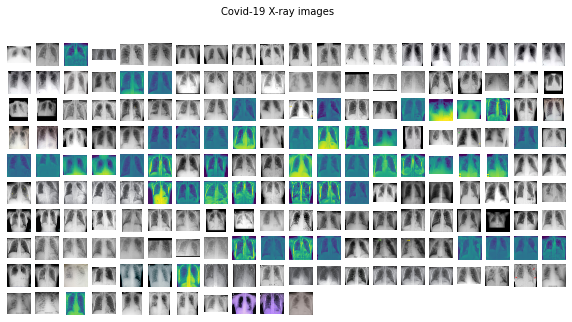

In [151]:
plots_from_files(covid_images, rows=10, maintitle="Covid-19 X-ray images")

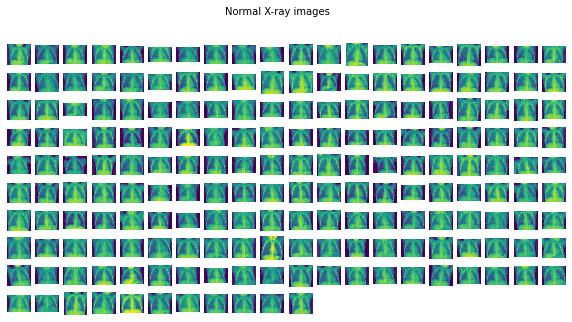

In [152]:
plots_from_files(normal_images, rows=10, maintitle="Normal X-ray images")

### models  

In [153]:
baseModel = VGG16(weights="imagenet", include_top=False, 
                  input_tensor=Input(shape=(224, 224, 3)))

58900480/58889256 [==============================] - 18s 0us/step


In [168]:
learning_rate = 1e-3         # [0.0001]
EPOCHS = 10            # [20]
BS = 8                 # [16, 32]
NODES_DENSE0 = 64      # [128]
DROPOUT = 0.5          # [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
MAXPOOL_SIZE = (4, 4)  # [(2,2) , (3,3)]
ROTATION_DEG = 15      # [10]
SPLIT = 0.2            # [0.1]

In [155]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=MAXPOOL_SIZE)(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(NODES_DENSE0, activation="relu")(headModel)
headModel = Dropout(DROPOUT)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [156]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [157]:
for layer in baseModel.layers:
    layer.trainable = False

#### Data Pre-processing 

In [158]:
imagePaths = list(paths.list_images(dataset_path))

In [160]:
data = []
labels = []
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))   
    
    
    data.append(image)
    labels.append(label)

In [161]:
data = np.array(data) / 255.0
labels = np.array(labels)

In [162]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [163]:
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels,
                                                  test_size=SPLIT,
                                                  stratify=labels,
                                                  random_state=42)

#### Augmentation 

In [164]:
trainAug = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [165]:
trainAug = ImageDataGenerator(rotation_range=ROTATION_DEG, 
                              fill_mode="nearest")

### Model Building and Training 

In [169]:
opt = Adam(lr=INIT_LR, decay=learning_rate / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [170]:
H = model.fit(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/10
38/38 [==============================] - 38s 984ms/step - loss: 0.6435 - accuracy: 0.6364 - val_loss: 0.4622 - val_accuracy: 0.9870
Epoch 2/10
38/38 [==============================] - 38s 1s/step - loss: 0.4391 - accuracy: 0.8822 - val_loss: 0.3327 - val_accuracy: 0.9481
Epoch 3/10
38/38 [==============================] - 37s 975ms/step - loss: 0.3301 - accuracy: 0.9226 - val_loss: 0.2219 - val_accuracy: 1.0000
Epoch 4/10
38/38 [==============================] - 37s 986ms/step - loss: 0.2456 - accuracy: 0.9394 - val_loss: 0.1494 - val_accuracy: 1.0000
Epoch 5/10
38/38 [==============================] - 37s 977ms/step - loss: 0.2009 - accuracy: 0.9562 - val_loss: 0.1024 - val_accuracy: 1.0000
Epoch 6/10
38/38 [==============================] - 37s 977ms/step - loss: 0.1413 - accuracy: 0.9764 - val_loss: 0.0798 - val_accuracy: 1.0000
Epoch 7/10
38/38 [==============================] - 37s 979ms/step - loss: 0.1107 - accuracy: 0.9731 - val_loss: 0.0568 - val_accuracy: 1.0000
Ep

In [171]:
 %tensorboard --logdir logs/fit

In [172]:
def plot_accuraccy(history):
    plt.style.use('seaborn-paper')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

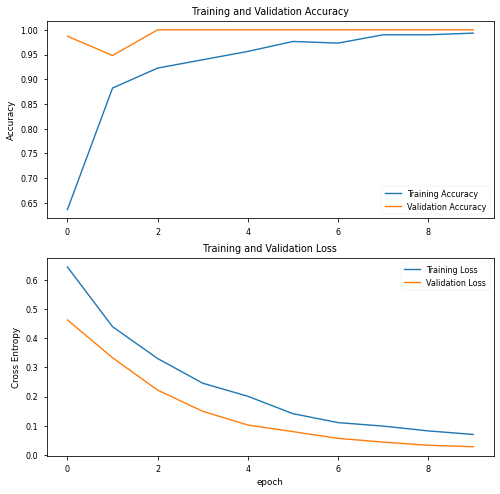

In [173]:
plot_accuraccy(H)

### Evaluation  

In [174]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        38
      normal       1.00      1.00      1.00        39

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77



### Confusion matrix  

In [178]:
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("\nacc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[38  0]
 [ 0 39]]

acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


###  save the model 

In [181]:
model.save(r"C:\Users\USER\X-Ray_Covide_development\input\model\covid_normal_model.h5")

### Testing the model in real images (validation) 

In [184]:
from tensorflow.keras.models import load_model

In [185]:
new_model = load_model(r"C:\Users\USER\X-Ray_Covide_development\input\model\covid_normal_model.h5")# Show the model architecture
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [186]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = new_model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        38
      normal       1.00      1.00      1.00        39

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77



### test on Covid images (From March/2020) 

In [193]:
def test_rx_image_for_Covid19(imagePath):
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)   
    img = np.array(img) / 255.0   
    
    pred = new_model.predict(img)
    pred_neg = round(pred[0][1]*100)
    pred_pos = round(pred[0][0]*100)    
    print('\n X-Ray Covid-19 Detection using AI - MJRovai')
    print('    [WARNING] - Only for didactic purposes')
    if np.argmax(pred, axis=1)[0] == 1:
        plt.title('\nPrediction: [NEGATIVE] with prob: {}% \nNo Covid-19\n'.format(
            pred_neg), fontsize=12)
    else:
        plt.title('\nPrediction: [POSITIVE] with prob: {}% \nPneumonia by Covid-19 Detected\n'.format(
            pred_pos), fontsize=12)   
        img_out = plt.imread(imagePath)
    plt.imshow(img_out)
    plt.savefig('../Image_Prediction/Image_Prediction.png')
    return pred_pos


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


FileNotFoundError: [Errno 2] No such file or directory: '../Image_Prediction/Image_Prediction.png'

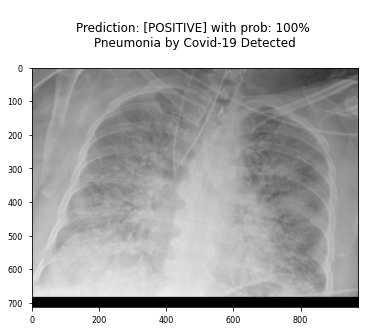

In [194]:
imagePath = r"C:\Users\USER\X-Ray_Covide_development\input\10_Covid_Images\dataset_validation\covid_validation\covid-19-rapidly-progressive-acute-respiratory-distress-syndrome-ards-day-2.jpg"
pred = test_rx_image_for_Covid19(imagePath)


 X-Ray Covid-19 Detection using AI - MJRovai
    [WARNING] - Only for didactic purposes


FileNotFoundError: [Errno 2] No such file or directory: '../Image_Prediction/Image_Prediction.png'

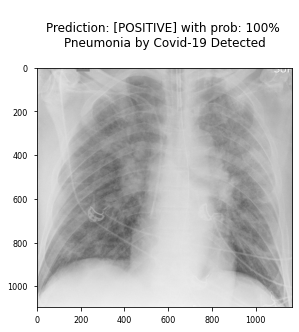

In [195]:
imagePath = r"C:\Users\USER\X-Ray_Covide_development\input\10_Covid_Images\dataset_validation\covid_validation\B2D20576-00B7-4519-A415-72DE29C90C34.jpeg"
pred = test_rx_image_for_Covid19(imagePath)

### Testando images in Batch 

In [197]:
validation_path = r"C:\Users\USER\X-Ray_Covide_development\input\10_Covid_Images\dataset_validation"

normal_val_images = list(paths.list_images(
    f"{validation_path}/normal_validation"))
non_covid_pneumonia_validation_images = list(paths.list_images(
    f"{validation_path}/non_covid_pneumonia_validation"))
covid_val_images = list(paths.list_images(
    f"{validation_path}/covid_validation"))

In [199]:
def test_rx_image_for_Covid19_batch(img_lst):
    neg_cnt = 0
    pos_cnt = 0
    predictions_score = []
    for img in img_lst:
        pred, neg_cnt, pos_cnt = test_rx_image_for_Covid19_2(img, neg_cnt, pos_cnt)
        predictions_score.append(pred)
    print ('{} positive detected in a total of {} images'.format(pos_cnt, (pos_cnt+neg_cnt)))
    return  predictions_score, neg_cnt, pos_cnt

In [200]:
img_lst = normal_val_images
normal_predictions_score, normal_neg_cnt, normal_pos_cnt = test_rx_image_for_Covid19_batch(img_lst)
normal_predictions_score

2 positive detected in a total of 207 images


[0.00017489136,
 5.347567e-05,
 5.308713e-05,
 0.00020122145,
 0.000110420646,
 0.013625322,
 0.001616413,
 6.8609465e-05,
 0.0019329332,
 0.0061455527,
 3.3843047e-05,
 0.00034511663,
 0.00016572372,
 0.00031166177,
 0.00016757555,
 0.00017461542,
 9.5795716e-05,
 0.08653779,
 0.00015960346,
 0.00039652095,
 0.0001508298,
 0.0028866397,
 0.00016124969,
 0.00059453095,
 0.00047194032,
 0.0024988733,
 1.568892e-05,
 2.7259055e-05,
 0.0074259085,
 0.00074665557,
 0.02947945,
 0.00010648399,
 0.18981703,
 0.0010964121,
 0.00023064061,
 0.0018525339,
 0.018447435,
 0.000836911,
 0.00017187724,
 0.0019415757,
 0.021871023,
 0.00039282738,
 0.009083042,
 0.00010707486,
 0.0008609966,
 0.0023796503,
 0.00021007808,
 8.238788e-05,
 0.00014850534,
 0.0012999089,
 0.00081336347,
 0.00023712016,
 0.00024059034,
 0.0001520964,
 5.777091e-05,
 0.010051144,
 0.00012978134,
 0.00014580932,
 0.00038268554,
 0.0002592655,
 0.005101546,
 3.3531174e-05,
 0.00036348126,
 4.760623e-05,
 3.8276095e-05,
 0.0

In [202]:
validation_path = r"C:\Users\USER\X-Ray_Covide_development\input\20_Chest_Xray\test"
normal_test_val_images = list(paths.list_images(f"{validation_path}/NORMAL"))
print("Normal Xray Images: ", len(normal_test_val_images))
pneumo_test_val_images = list(paths.list_images(f"{validation_path}/PNEUMONIA"))
print("Pneumo Xray Images: ", len(pneumo_test_val_images))

Normal Xray Images:  234
Pneumo Xray Images:  390


In [204]:
covid_val_images

['C:\\Users\\USER\\X-Ray_Covide_development\\input\\10_Covid_Images\\dataset_validation/covid_validation\\01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg',
 'C:\\Users\\USER\\X-Ray_Covide_development\\input\\10_Covid_Images\\dataset_validation/covid_validation\\03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg',
 'C:\\Users\\USER\\X-Ray_Covide_development\\input\\10_Covid_Images\\dataset_validation/covid_validation\\0a7faa2a.jpg',
 'C:\\Users\\USER\\X-Ray_Covide_development\\input\\10_Covid_Images\\dataset_validation/covid_validation\\1-s2.0-S0140673620303706-fx1_lrg.jpg',
 'C:\\Users\\USER\\X-Ray_Covide_development\\input\\10_Covid_Images\\dataset_validation/covid_validation\\1-s2.0-S1684118220300608-main.pdf-001.jpg',
 'C:\\Users\\USER\\X-Ray_Covide_development\\input\\10_Covid_Images\\dataset_validation/covid_validation\\1-s2.0-S1684118220300608-main.pdf-002.jpg',
 'C:\\Users\\USER\\X-Ray_Covide_development\\input\\10_Covid_Images\\dataset_validation/covid_validation\\1-s2.0-S1684118220300682-mai

In [205]:
img_lst = covid_val_images
covid_predictions_score, covid_neg_cnt, covid_pos_cnt = test_rx_image_for_Covid19_batch(img_lst)
covid_predictions_score

197 positive detected in a total of 199 images


[0.9999995,
 0.9999627,
 0.99053735,
 0.99091995,
 0.99851304,
 0.9933221,
 0.9997496,
 0.9996811,
 0.9115265,
 0.87511605,
 0.99996674,
 0.99958175,
 0.9999944,
 0.99991167,
 0.9999747,
 0.99999654,
 0.99999416,
 0.9999459,
 0.9999994,
 0.99997044,
 0.99999416,
 0.9999757,
 0.99999547,
 0.99979204,
 0.99997485,
 0.9999896,
 0.9999912,
 0.9259211,
 0.9999789,
 0.9999745,
 0.9999763,
 0.9999881,
 0.99999774,
 0.99963915,
 0.9999602,
 0.9996903,
 0.99105436,
 0.9998975,
 0.99980766,
 0.99999976,
 0.9999999,
 0.99999976,
 0.9258047,
 0.99955434,
 0.99966335,
 0.9999876,
 0.9149109,
 0.99980325,
 0.99999404,
 0.9999924,
 0.99684995,
 0.9999633,
 0.9999441,
 0.99986994,
 0.99645716,
 0.99973446,
 0.9999974,
 0.9999939,
 0.9996233,
 0.97857875,
 0.99374384,
 0.9999925,
 0.9998944,
 0.9999753,
 0.97972643,
 0.9999602,
 0.9999951,
 0.9999894,
 0.9999839,
 0.9999871,
 0.9744881,
 0.9998067,
 0.99999225,
 0.9930428,
 0.9999621,
 0.99998474,
 0.9999149,
 0.9997675,
 0.9998246,
 0.99993193,
 0.999

C:\Users\USER\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\USER\anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


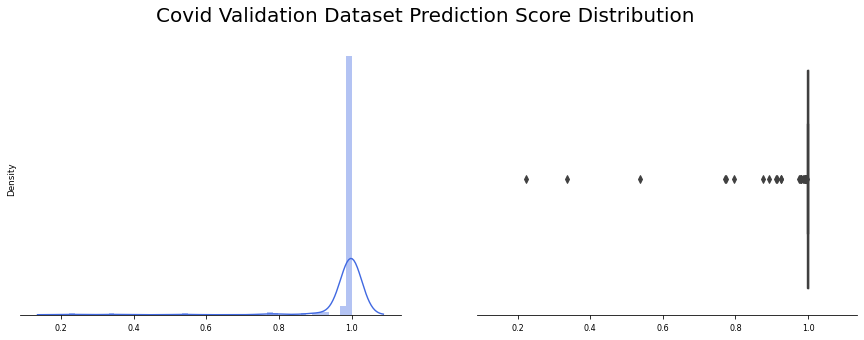

In [206]:
dist = covid_predictions_score
plot_prediction_distribution(dist, "Covid Validation Dataset Prediction Score Distribution")

In [207]:
print ('Covid Validation Dataset Prediction Score Mean: ',stat.mean(dist))
print ('Covid Validation Dataset Prediction Score Median: ',stat.median(dist))

Covid Validation Dataset Prediction Score Mean:  0.98273814
Covid Validation Dataset Prediction Score Median:  0.99991167


In [208]:
img_lst = normal_val_images
normal_predictions_score, normal_neg_cnt, normal_pos_cnt = test_rx_image_for_Covid19_batch(
    img_lst)
normal_predictions_score

2 positive detected in a total of 207 images


[0.00017489136,
 5.347567e-05,
 5.308713e-05,
 0.00020122145,
 0.000110420646,
 0.013625322,
 0.001616413,
 6.8609465e-05,
 0.0019329332,
 0.0061455527,
 3.3843047e-05,
 0.00034511663,
 0.00016572372,
 0.00031166177,
 0.00016757555,
 0.00017461542,
 9.5795716e-05,
 0.08653779,
 0.00015960346,
 0.00039652095,
 0.0001508298,
 0.0028866397,
 0.00016124969,
 0.00059453095,
 0.00047194032,
 0.0024988733,
 1.568892e-05,
 2.7259055e-05,
 0.0074259085,
 0.00074665557,
 0.02947945,
 0.00010648399,
 0.18981703,
 0.0010964121,
 0.00023064061,
 0.0018525339,
 0.018447435,
 0.000836911,
 0.00017187724,
 0.0019415757,
 0.021871023,
 0.00039282738,
 0.009083042,
 0.00010707486,
 0.0008609966,
 0.0023796503,
 0.00021007808,
 8.238788e-05,
 0.00014850534,
 0.0012999089,
 0.00081336347,
 0.00023712016,
 0.00024059034,
 0.0001520964,
 5.777091e-05,
 0.010051144,
 0.00012978134,
 0.00014580932,
 0.00038268554,
 0.0002592655,
 0.005101546,
 3.3531174e-05,
 0.00036348126,
 4.760623e-05,
 3.8276095e-05,
 0.0

C:\Users\USER\anaconda3\envs\myenv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\USER\anaconda3\envs\myenv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


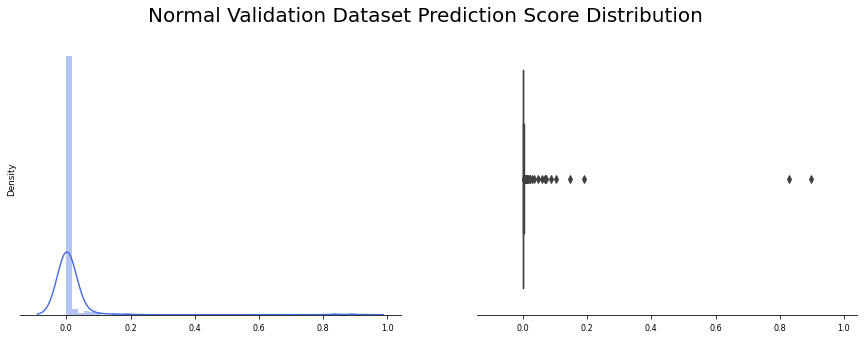

In [209]:
dist = normal_predictions_score
plot_prediction_distribution(dist, "Normal Validation Dataset Prediction Score Distribution")


### Part 3 — Model 2 — Covid/Pneumo
